### Load Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from adjustText import adjust_text
import seaborn as sns
from scipy import sparse
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

### Load Data

In [2]:
ratings = pd.read_csv("./ratings.csv")
data = ratings.iloc[:, : -1]

### Split into train and test

In [3]:
# Maximum user ID
max_users = np.max(data.iloc[:, 0])

# Get unique users in order
unique_users_ordered = pd.unique(data.iloc[:, 0])

# Filter data to include only unique users
filtered_data = data[data.iloc[:, 0].isin(unique_users_ordered)].copy()

# Map old user IDs to new sequential IDs
user_id_map = {old: new for new, old in enumerate(unique_users_ordered)}
filtered_data.iloc[:, 0] = filtered_data.iloc[:, 0].map(user_id_map)

# Map old item IDs to new sequential IDs
unique_items = filtered_data.iloc[:, 1].unique()
item_id_map = {old: new for new, old in enumerate(unique_items)}
filtered_data.iloc[:, 1] = filtered_data.iloc[:, 1].map(item_id_map)

# Shuffle data
filtered_data = filtered_data.sample(frac=1, random_state=99).reset_index(drop=True)

# Number of users, items, and ratings
n_users = filtered_data.iloc[:, 0].nunique()
n_items = filtered_data.iloc[:, 1].nunique()
n_ratings = len(filtered_data)

# Initialize rating lists
user_ratings = [[] for _ in range(n_users)]
item_ratings = [[] for _ in range(n_items)]

# Populate rating lists
for user, item, rating in tqdm(filtered_data.iloc[:n_ratings, :].values):
    user_ratings[int(user)].append((int(item), float(rating)))
    item_ratings[int(item)].append((int(user), float(rating)))


100%|██████████| 32000204/32000204 [01:04<00:00, 496906.68it/s]


In [ ]:
# Load additional data
data = np.load("all_data.npz", allow_pickle=True)

# Extract arrays from loaded data
user_bias = data["user_bias"]
item_bias = data["item_bias"]
user_embedding = data["user_embedding"]
item_embedding = data["item_embedding"]
feature_embedding = data["feature_embedding"]
nll_history = data["nll_history"]
train_rmse_history = data["train_rmse_history"]
test_rmse_history = data["test_rmse_history"]
item_id_map = data["item_id_map"]

# Compute mean of training ratings
mu_train = filtered_data.iloc[:, 2].mean()


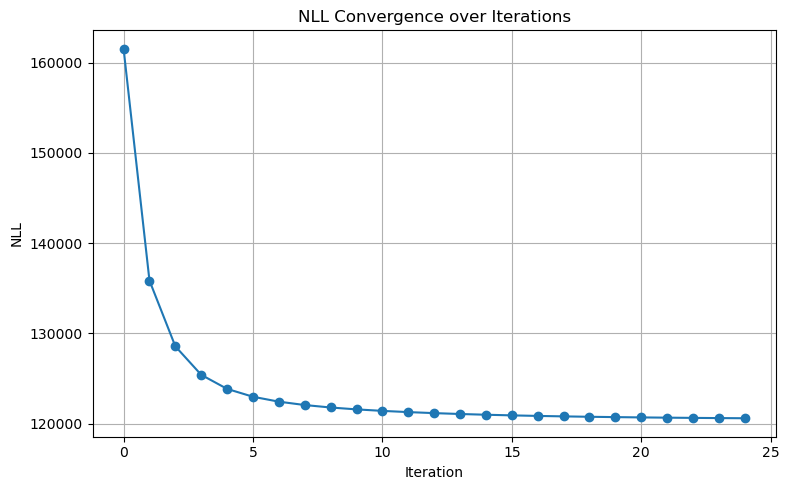

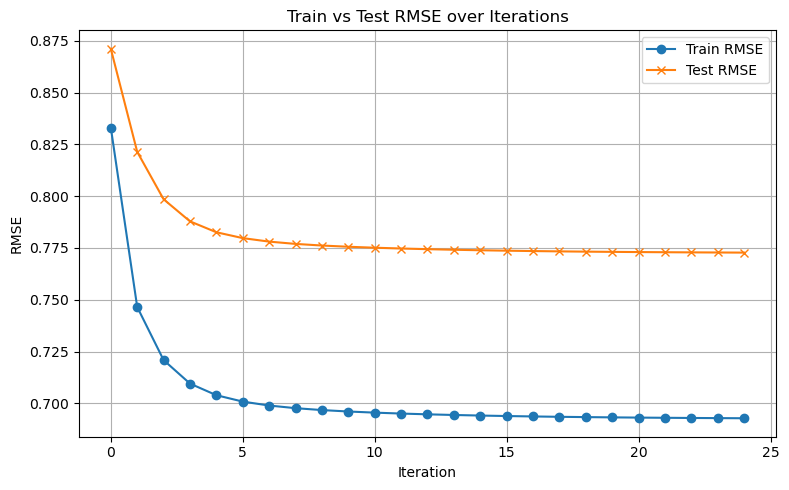

In [5]:
# Plot NLL convergence over iterations
plt.figure(figsize=(8, 5))
plt.plot(nll_history, marker="o")
plt.xlabel("Iteration")
plt.ylabel("NLL")
plt.title("NLL Convergence over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Train vs Test RMSE over iterations
plt.figure(figsize=(8, 5))
plt.plot(train_rmse_history, label="Train RMSE", marker="o")
plt.plot(test_rmse_history, label="Test RMSE", marker="x")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE over Iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
def extract_year(title):
    """Extract the year from a movie title."""
    if match := re.search(r"\((\d{4})\)", title):
        return int(match.group(1))
    return None

# Load movies data
movies = pd.read_csv("movies.csv")

# Extract year and decade
movies["year"] = movies["title"].map(extract_year)
movies["decade"] = ((movies["year"] // 10) * 10).astype("Int64")
movies["decade"] = movies["decade"].astype("string") + "s"
movies.loc[movies["year"] < 1950, "decade"] = "pre 1950s"

# Create mapping from movieId to title
movieid_to_title = dict(zip(movies["movieId"], movies["title"]))

# Process genres
movies["genres"] = movies["genres"].str.split("|").apply(
    lambda lst: [g for g in lst if g != "(no genres listed)"]
)

# Ensure decade is a string and handle missing values
movies["decade"] = movies["decade"].astype("string")
movies["decade"] = movies["decade"].where(movies["decade"].notna(), None)
movies = movies[["movieId", "title", "genres", "decade"]]

# Prepare features for encoding
movies["decade_filled"] = movies["decade"].fillna("SKIP_THIS")

# Encode genres
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(movies["genres"])

# Encode decades
valid_decades = sorted(
    [d for d in movies["decade_filled"].dropna().unique() if d != "SKIP_THIS"]
)
ohe = OneHotEncoder(
    sparse_output=False, handle_unknown="ignore", categories=[valid_decades]
)
decade_features = ohe.fit_transform(movies[["decade_filled"]])

# Combine features
item_features = np.hstack([genre_features, decade_features])

# Feature names
decade_feature_names = [f"decade_{d}" for d in valid_decades]
genre_feature_names = [f"genre_{g}" for g in mlb.classes_]
feature_names = genre_feature_names + decade_feature_names


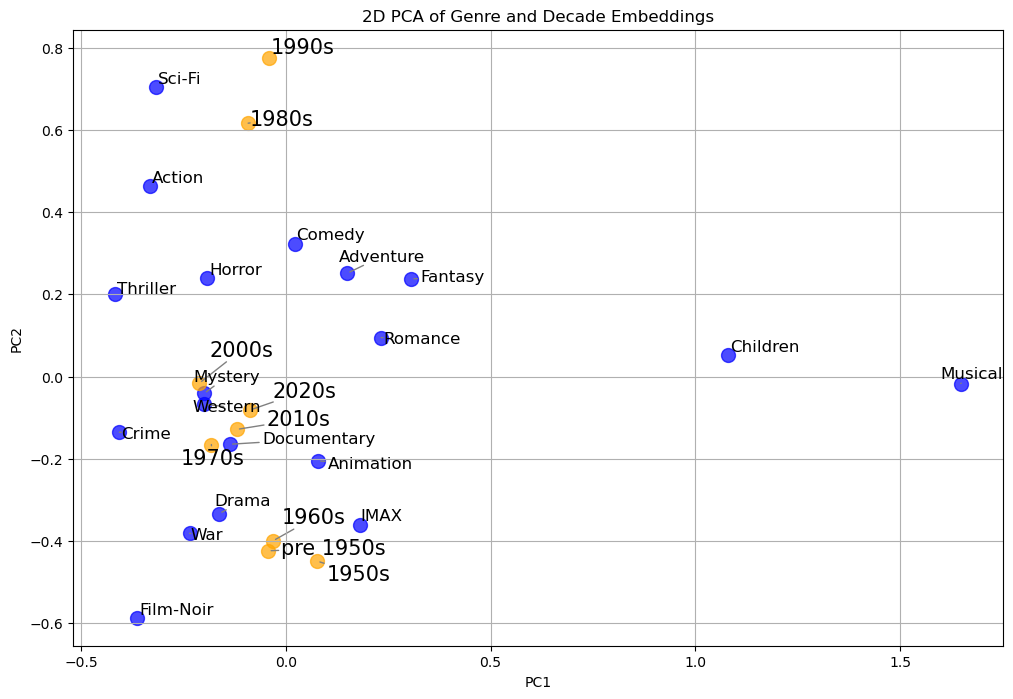

In [7]:
# Map item indices to movieIds and titles
item_index_to_movieid = {v: k for k, v in item_id_map.item().items()}
item_index_to_title = {
    idx: movieid_to_title[movieid]
    for idx, movieid in item_index_to_movieid.items()
}

# Number of genre features
n_genres = len(mlb.classes_)

# Select only genre embeddings
genre_embedding = feature_embedding[:n_genres, :]

# Number of decades
n_decades = len(ohe.categories_[0])

# Select only decade embeddings
decade_embedding = feature_embedding[-n_decades:, :]

# Combine genre and decade embeddings
combined_embedding = np.vstack([genre_embedding, decade_embedding])

# Reduce to 2D using PCA
pca = PCA(n_components=2)
combined_emb_2d = pca.fit_transform(combined_embedding)

genre_emb_2d = combined_emb_2d[:n_genres, :]
decade_emb_2d = combined_emb_2d[n_genres:, :]

# Plot 2D PCA
plt.figure(figsize=(12, 8))

# Scatter points
plt.scatter(genre_emb_2d[:, 0], genre_emb_2d[:, 1], s=100, color="blue", alpha=0.7)
plt.scatter(decade_emb_2d[:, 0], decade_emb_2d[:, 1], s=100, color="orange", alpha=0.7)

# Add text labels
texts = []
for i, genre in enumerate(mlb.classes_):
    texts.append(plt.text(genre_emb_2d[i, 0], genre_emb_2d[i, 1], genre, fontsize=12))

for i, decade in enumerate(ohe.categories_[0]):
    texts.append(plt.text(decade_emb_2d[i, 0], decade_emb_2d[i, 1], decade, fontsize=15))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray"))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA of Genre and Decade Embeddings")
plt.grid(True)
plt.show()

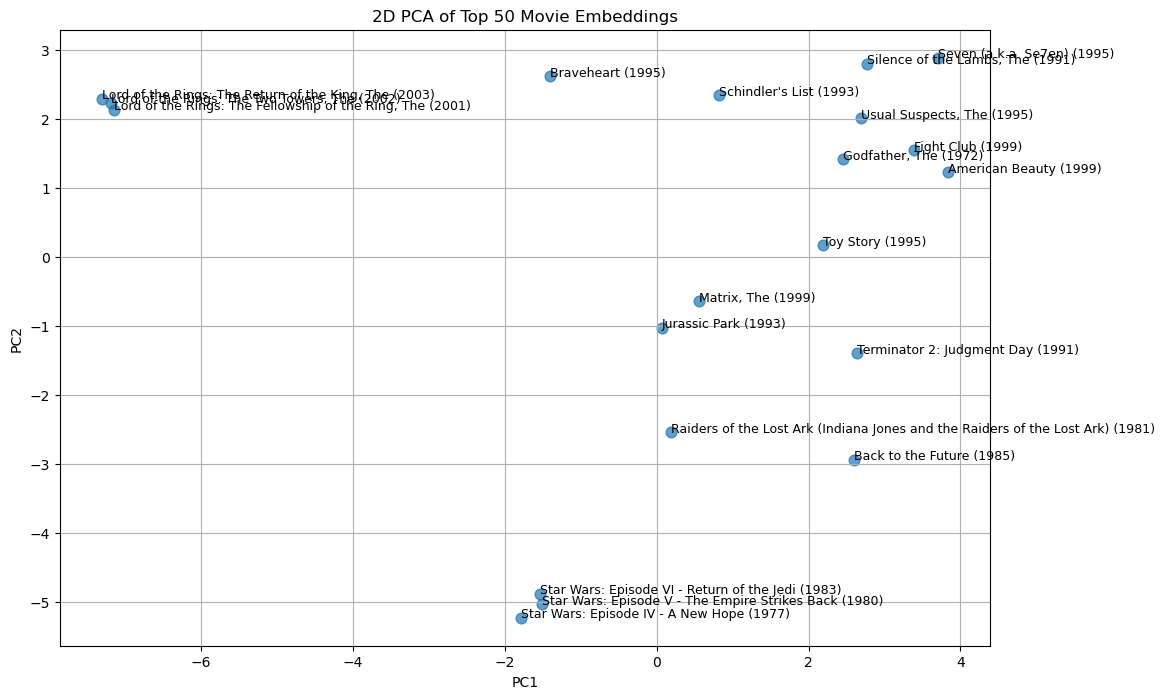

In [8]:
# Count number of ratings per item
item_counts = np.array([len(r) for r in item_ratings])

# Indices of top 50 most-rated movies (excluding first 3)
top_indices = item_counts.argsort()[::-1][3:23]

# Embeddings for top 50 movies
top_embeddings = item_embedding[top_indices]

# Reduce embeddings to 2D using PCA
pca = PCA(n_components=2)
item_emb_2d = pca.fit_transform(top_embeddings)

# Plot 2D PCA of top movies
plt.figure(figsize=(12, 8))
plt.scatter(item_emb_2d[:, 0], item_emb_2d[:, 1], s=60, alpha=0.7)

# Add movie titles as labels
for i, idx in enumerate(top_indices):
    plt.text(item_emb_2d[i, 0], item_emb_2d[i, 1],
             item_index_to_title[idx], fontsize=9)

plt.title("2D PCA of Top 50 Movie Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


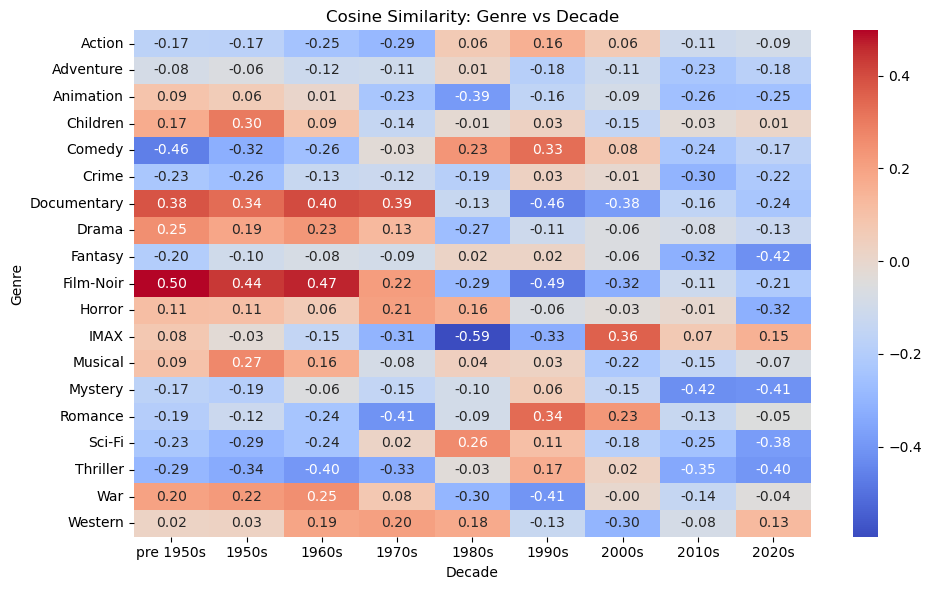

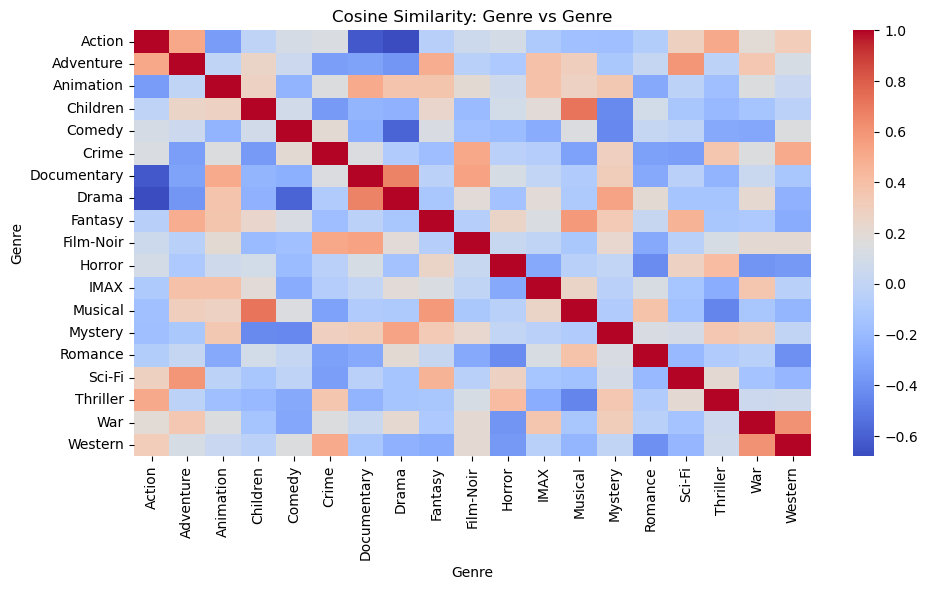

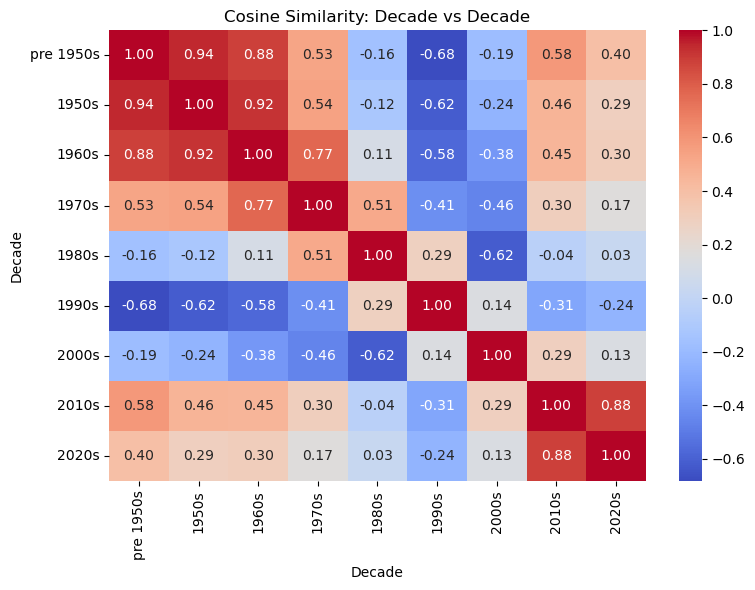

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Reorder decades so 'pre 1950s' comes first
decades = list(ohe.categories_[0])
pre_idx = decades.index("pre 1950s")
decades = ["pre 1950s"] + [d for i, d in enumerate(decades) if i != pre_idx]

# Select decade embeddings (last n_decades rows) and reorder
decade_embedding = feature_embedding[-n_decades:, :]
decade_embedding = np.vstack([
    decade_embedding[pre_idx, :],
    np.delete(decade_embedding, pre_idx, axis=0)
])

# ===================== COSINE SIMILARITIES =====================

# --- Genre vs Decade ---
genre_decade_sim = cosine_similarity(genre_embedding, decade_embedding)
genre_decade_df = pd.DataFrame(genre_decade_sim, index=mlb.classes_, columns=decades)

plt.figure(figsize=(10, 6))
sns.heatmap(genre_decade_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Cosine Similarity: Genre vs Decade")
plt.xlabel("Decade")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# --- Genre vs Genre ---
genre_genre_sim = cosine_similarity(genre_embedding)
genre_genre_df = pd.DataFrame(genre_genre_sim, index=mlb.classes_, columns=mlb.classes_)

plt.figure(figsize=(10, 6))
sns.heatmap(genre_genre_df, annot=False, cmap="coolwarm", cbar=True)
plt.title("Cosine Similarity: Genre vs Genre")
plt.xlabel("Genre")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# --- Decade vs Decade ---
decade_decade_sim = cosine_similarity(decade_embedding)
decade_decade_df = pd.DataFrame(decade_decade_sim, index=decades, columns=decades)

plt.figure(figsize=(8, 6))
sns.heatmap(decade_decade_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Cosine Similarity: Decade vs Decade")
plt.xlabel("Decade")
plt.ylabel("Decade")
plt.tight_layout()
plt.show()

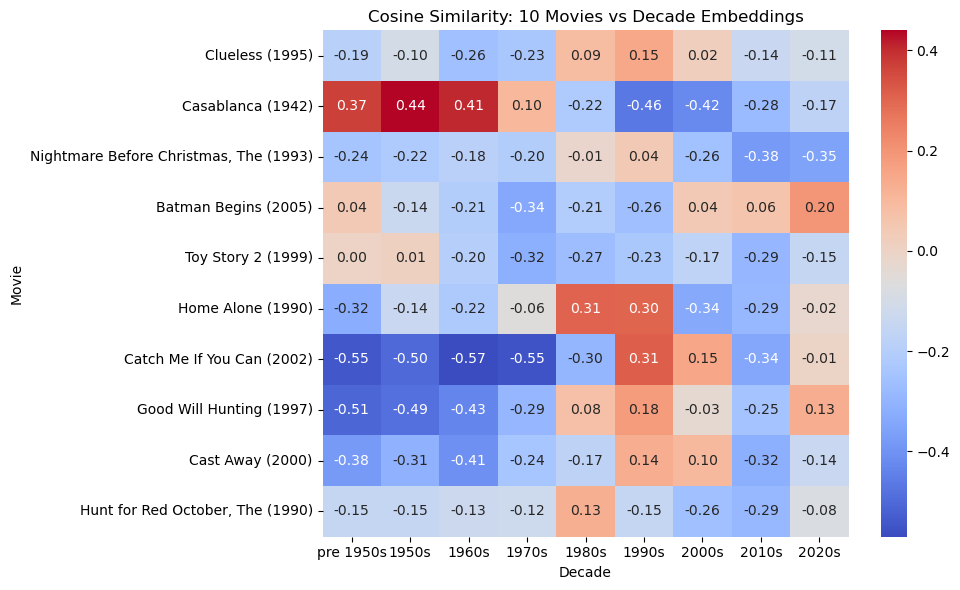

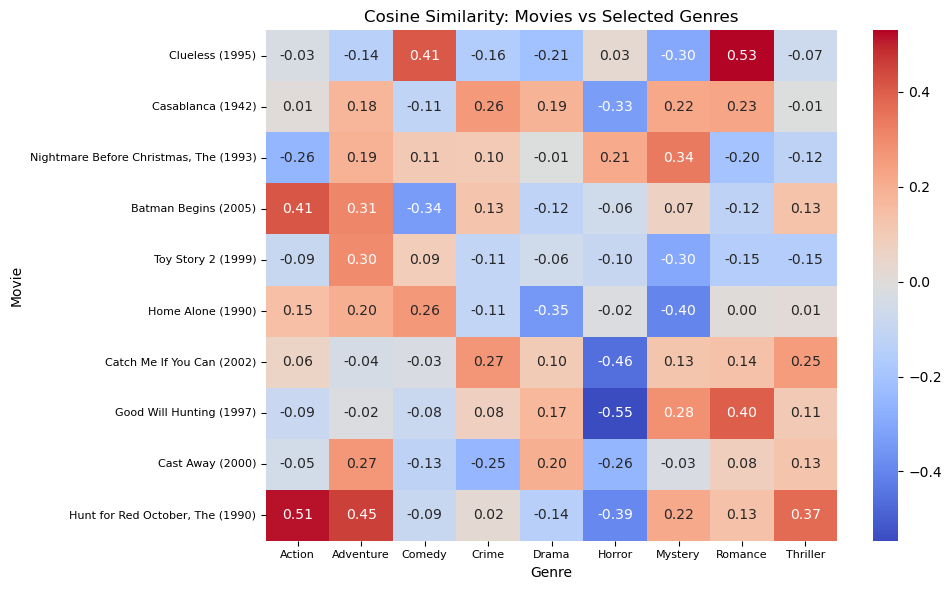

In [ ]:
# ===================== TOP MOVIES =====================
#np.random.seed(99)
top_k = 10
top_1000_indices = item_counts.argsort()[::-1][:200]
top_indices = np.random.choice(top_1000_indices, size=top_k, replace=False)
top_embeddings = item_embedding[top_indices]
top_titles = [item_index_to_title[idx] for idx in top_indices]

# ===================== GENRE SUBSET =====================
subset_genres = [
    "Action", "Adventure", "Comedy", "Crime",
    "Drama", "Horror", "Mystery", "Romance", "Thriller"
]
subset_indices = [i for i, g in enumerate(mlb.classes_) if g in subset_genres]
subset_genre_embedding = genre_embedding[subset_indices, :]
subset_genre_names = [mlb.classes_[i] for i in subset_indices]

# ===================== COSINE SIMILARITIES =====================

# Top movies vs all decades
movie_decade_sim = cosine_similarity(top_embeddings, decade_embedding)
movie_decade_df = pd.DataFrame(movie_decade_sim, index=top_titles, columns=decades)

plt.figure(figsize=(10, 6))
sns.heatmap(movie_decade_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Cosine Similarity: 10 Movies vs Decade Embeddings")
plt.xlabel("Decade")
plt.ylabel("Movie")
plt.tight_layout()
plt.show()

# Top movies vs subset of genres
movie_genre_sim = cosine_similarity(top_embeddings, subset_genre_embedding)
movie_genre_df = pd.DataFrame(movie_genre_sim, index=top_titles, columns=subset_genre_names)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(movie_genre_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.title("Cosine Similarity: Movies vs Selected Genres")
plt.xlabel("Genre")
plt.ylabel("Movie")
plt.tight_layout()
plt.show()

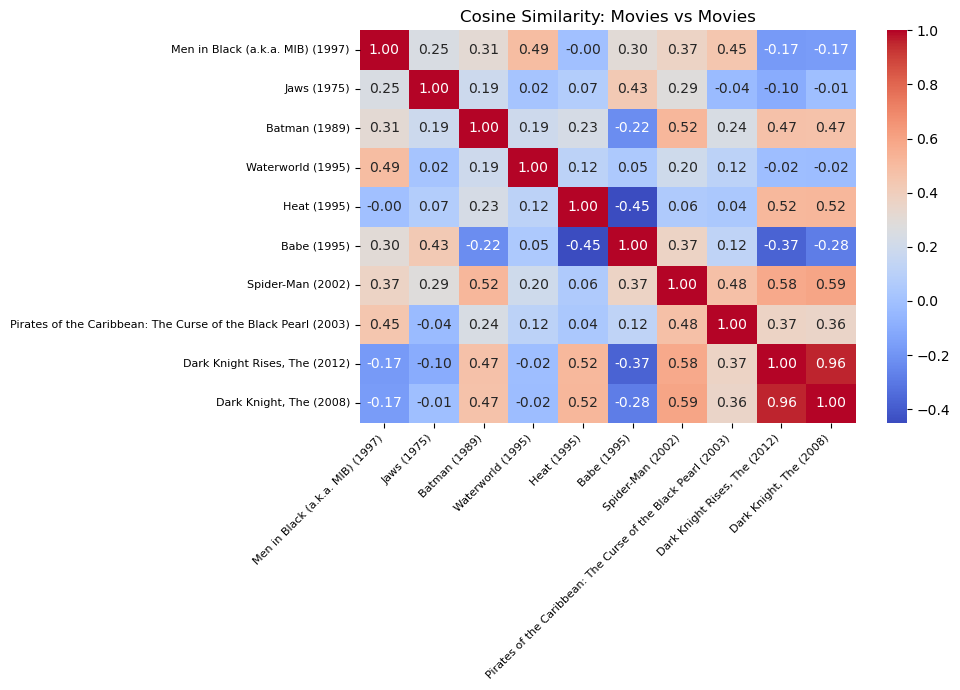

In [ ]:
# Set random seed for reproducibility
#np.random.seed(12)

# ===================== TOP MOVIES =====================
top_k = 10
top_100_indices = item_counts.argsort()[::-1][:151]
top_indices = np.random.choice(top_100_indices, size=top_k, replace=False)
top_embeddings = item_embedding[top_indices]
top_titles = [item_index_to_title[idx] for idx in top_indices]

# Compute cosine similarity between top movies themselves
movie_movie_sim = cosine_similarity(top_embeddings, top_embeddings)
movie_movie_df = pd.DataFrame(movie_movie_sim, index=top_titles, columns=top_titles)

# Plot heatmap
plt.figure(figsize=(10, 7))
ax = sns.heatmap(movie_movie_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
plt.title("Cosine Similarity: Movies vs Movies")
plt.tight_layout()
plt.show()


In [12]:
def normalize_title(title):
    """Remove year in parentheses and extra whitespace, convert to lowercase."""
    return re.sub(r"\s*\(\d{4}\)", "", title).strip().lower()


def find_similar_movies(movie_title, top_n=5):
    """
    Find the top N movies most similar to the given movie title
    based on cosine similarity of embeddings.
    
    Parameters:
        movie_title (str): The movie title to search for.
        top_n (int): Number of similar movies to return.
    
    Returns:
        list of tuples: [(title, similarity), ...] or None if movie not found.
    """
    # Normalize input title
    norm_input = normalize_title(movie_title)

    # Find index of the movie
    idx = None
    for i, title in item_index_to_title.items():
        if normalize_title(title) == norm_input:
            idx = i
            break

    if idx is None:
        return None

    # Compute cosine similarity with all movies
    sims = cosine_similarity(item_embedding[idx:idx+1], item_embedding)[0]

    # Get top N similar movies (excluding itself)
    top_indices = sims.argsort()[::-1][1:top_n + 1]
    similar_movies = [
        (item_index_to_title[i], float(round(sims[i], 4))) for i in top_indices
    ]

    return similar_movies

In [15]:
# Find similar movies
similar_movies = find_similar_movies("Toy Story", top_n=20)

# Print header
print(f"{'Movie':50} {'Similarity':>10}")
print("-" * 61)

# Print each similar movie and its similarity
for movie, sim in similar_movies:
    print(f"{movie:50} {sim:10.4f}")


Movie                                              Similarity
-------------------------------------------------------------
Toy Story 2 (1999)                                     0.9783
Toy Story 3 (2010)                                     0.9555
Monsters, Inc. (2001)                                  0.9345
Finding Nemo (2003)                                    0.9342
Up (2009)                                              0.8941
Bug's Life, A (1998)                                   0.8934
Ratatouille (2007)                                     0.8822
Incredibles, The (2004)                                0.8822
Wreck-It Ralph (2012)                                  0.8519
Zootopia (2016)                                        0.8500
WALL·E (2008)                                          0.8341
Monsters University (2013)                             0.8324
Toy Story 4 (2019)                                     0.8274
Spirited (2022)                                        0.8244
Iron Gia

In [14]:
import numpy as np
import pandas as pd

# Minimum number of ratings to consider
min_ratings = 50_000

# Compute number of ratings and standard deviation per item
item_stats = filtered_data.groupby(filtered_data.columns[1])[filtered_data.columns[2]].agg(
    ['count', 'std']
)

# Filter items with at least `min_ratings`
item_stats = item_stats[item_stats['count'] >= min_ratings]

# Compute embedding magnitude for these items
item_stats['magnitude'] = item_stats.index.to_series().apply(
    lambda idx: np.linalg.norm(item_embedding[idx])
)

# Map item indices to movie titles
item_stats['Movie'] = item_stats.index.to_series().map(item_index_to_title)

# Reorder and rename columns
item_stats = item_stats[['Movie', 'magnitude', 'count', 'std']]
item_stats.columns = ['Movie', 'Embedding Magnitude', 'Num Ratings', 'Rating StdDev']

# Top 10 largest magnitude
top10_largest = item_stats.sort_values(by='Embedding Magnitude', ascending=False).head(10)

# Top 10 smallest magnitude
top10_smallest = item_stats.sort_values(by='Embedding Magnitude', ascending=True).head(10)

# Compute correlation between embedding magnitude and rating standard deviation
corr = item_stats['Embedding Magnitude'].corr(item_stats['Rating StdDev'])

# Display results
print("Top 10 Movies by Embedding Magnitude:")
print(top10_largest.to_string(index=False))

print("\nTop 10 Movies by Smallest Embedding Magnitude:")
print(top10_smallest.to_string(index=False))

print(f"\nCorrelation between embedding magnitude and rating StdDev: {corr:.4f}")

Top 10 Movies by Embedding Magnitude:
                                                    Movie  Embedding Magnitude  Num Ratings  Rating StdDev
    Lord of the Rings: The Return of the King, The (2003)             9.517270        67449       1.010360
            Lord of the Rings: The Two Towers, The (2002)             9.373606        67463       0.997060
Lord of the Rings: The Fellowship of the Ring, The (2001)             9.347728        73122       1.009276
                Star Wars: Episode IV - A New Hope (1977)             7.938498        85010       0.993047
    Star Wars: Episode V - The Empire Strikes Back (1980)             7.666357        72151       0.955928
        Star Wars: Episode VI - Return of the Jedi (1983)             7.541248        67496       0.945215
                                      Pulp Fiction (1994)             7.423832        98409       0.945559
                                       Matrix, The (1999)             6.619014        93808       0.907191